In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [21]:
from nba_api.stats.static import teams 
from nba_api.stats.endpoints import leaguegamefinder 
import pandas as pd
import csv

teams = teams.get_teams()
#print(teams)

all_games = leaguegamefinder.LeagueGameFinder().get_data_frames()[0]

# List of current NBA team IDs
current_teams = [1610612737, 1610612738, 1610612740, 1610612741, 1610612742, 1610612743, 1610612744, 1610612745, 1610612746, 1610612747, 1610612748, 1610612749, 1610612750, 1610612751, 1610612752, 1610612753, 1610612754, 1610612755, 1610612756, 1610612757, 1610612758, 1610612759, 1610612760, 1610612761, 1610612762, 1610612763, 1610612764, 1610612765, 1610612766]
#print(current_teams)

# Filter the data to include only current NBA teams
data = all_games[all_games['TEAM_ID'].isin(current_teams)]
#print('base_data = ',data.columns)

#adding PER
data['PER'] = (data['PTS'] + data['REB'] + data['AST'] + data['STL'] + data['BLK'] -
             data['FGM'] - data['FTM'] - data['TOV'])


#***PRE PROCESSING***
#*Date transformations
# Convert the date column to datetime format
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Extract numerical features from the date column
data['YEAR'] = data['GAME_DATE'].dt.year
data['MONTH'] = data['GAME_DATE'].dt.month
data['DAY'] = data['GAME_DATE'].dt.day


#**Convert all non-numeric values in a column
# Encode non-numeric values in the 'TEAM_ID' column as categorical variables
data_encoded = pd.get_dummies(data, columns=['TEAM_ID'], prefix='TEAM')


#**Drop Missing values
# Drop rows with missing values
data_encoded = data_encoded.dropna()

# Filter the data to include only selected columns
data_encoded_selected = data_encoded.iloc[:, :31]

# Get Unique Teams prior to modeling <takes out all the other games for these teams, find why Mavs are showing up twice in final set>
#data_encoded_unique = data_encoded_selected.drop_duplicates(subset='TEAM_NAME').copy()

# Check the updated column names in the DataFrame
print('encoded_data = ',data_encoded_selected.columns)
#print(data_encoded_selected)

# Filter the data for the 2022-2023 NBA season
#could also use season_id = 42022
start_date = pd.to_datetime('2022-10-01')
end_date = pd.to_datetime('2023-06-30')
season_data = data_encoded_selected[(data_encoded_selected['GAME_DATE'] >= start_date) & (data_encoded_selected['GAME_DATE'] <= end_date)].copy()

# Encode 'WL' column as 1 for 'W' (win) and 0 for 'L' (loss)
season_data['WL_encoded'] = season_data['WL'].apply(lambda x: 1 if x == 'W' else 0)
print(season_data.head())




encoded_data =  Index(['SEASON_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE',
       'MATCHUP', 'WL', 'MIN', 'PTS', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PLUS_MINUS', 'PER', 'YEAR', 'MONTH', 'DAY'],
      dtype='object')
    SEASON_ID TEAM_ABBREVIATION       TEAM_NAME     GAME_ID  GAME_DATE  \
652     42022               DEN  Denver Nuggets  0042200405 2023-06-12   
653     42022               MIA      Miami Heat  0042200405 2023-06-12   
670     42022               DEN  Denver Nuggets  0042200404 2023-06-09   
684     42022               MIA      Miami Heat  0042200404 2023-06-09   
698     42022               MIA      Miami Heat  0042200403 2023-06-07   

         MATCHUP WL  MIN  PTS  FGM  ...  STL  BLK  TOV  PF  PLUS_MINUS  PER  \
652  DEN vs. MIA  W  240   94   38  ...    6    7   14  13         5.0  120   
653    MIA @ DEN  L  240   89   33  ...    9    7  

C:\Users\ghadf\AppData\Local\Temp\ipykernel_15928\2714108737.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['PER'] = (data['PTS'] + data['REB'] + data['AST'] + data['STL'] + data['BLK'] -
C:\Users\ghadf\AppData\Local\Temp\ipykernel_15928\2714108737.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])
C:\Users\ghadf\AppData\Local\Temp\ipykernel_15928\2714108737.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

C:\Users\ghadf\AppData\Local\Temp\ipykernel_15928\3982916899.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(season_data.corr()) #coor for coordinates


     SEASON_ID  TEAM_NAME     GAME_ID  MATCHUP  MIN  PTS  FGM  FGA  FG_PCT  \
652      42022          6  0042200405      391  240   94   38   84   0.452   
653      42022         14  0042200405      819  240   89   33   96   0.344   
670      42022          6  0042200404      362  242  108   39   79   0.494   
684      42022         14  0042200404      848  240   95   35   78   0.449   
698      42022         14  0042200403      848  240   94   34   92   0.370   
...        ...        ...         ...      ...  ...  ...  ...  ...     ...   
8242     12022         22  0012200008     1307  238  124   48   98   0.490   
8243     12022          3  0012200005      176  241   93   35  101   0.347   
8244     12022         26  0012200006     1568  242  114   42   87   0.483   
8245     12022         13  0012200003      769  239  107   38   77   0.494   
8246     12022         15  0012200003      913  240  102   37   86   0.430   

      FG3M  ...  AST  STL  BLK  TOV  PF  PLUS_MINUS  PER  YEAR 

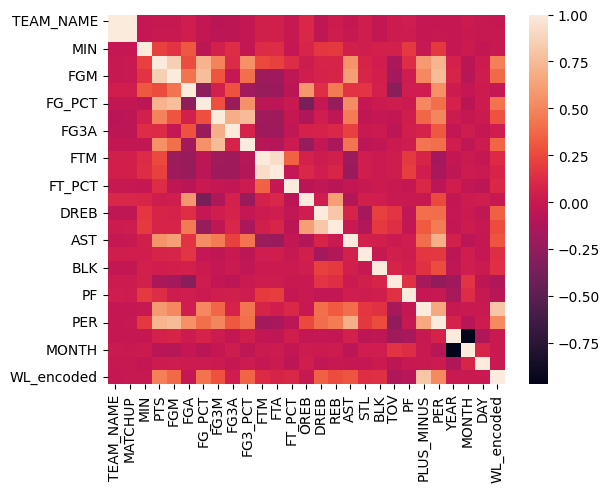

In [28]:
# Data Visualization to understand the variables better
# Heat Map

sns.heatmap(season_data.corr()) #coor for coordinates


import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

# Define the columns for the dependent (y) and independent (X) variables
y_column = 'WL_encoded'

# Update season_data with encoded features
labelencoder = LabelEncoder()
season_data['TEAM_NAME'] = labelencoder.fit_transform(season_data['TEAM_NAME'])
season_data['MATCHUP'] = labelencoder.fit_transform(season_data['MATCHUP'])

# Drop any rows with missing values from season_data
season_data.dropna(inplace=True)

# Define X and y using the updated season_data DataFrame
X = season_data.drop(columns=[y_column,'GAME_DATE','TEAM_ABBREVIATION','WL'])
y = season_data[y_column]

print(X) #checking on the columns to ensure coded and the length is long enough for the season/playoffs

# Confirm the shape of X and y after handling missing values and encoding
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)




In [27]:
from sklearn.metrics import mean_squared_error, r2_score
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Create a linear regression model and fit it to the training data
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Use the trained model to predict the NBA championship winner based on the test data
y_pred_lr = lr_model.predict(X_test)

# Get the team names from the original dataset for the test set
team_names_test = season_data.loc[X_test.index, 'TEAM_NAME'].reset_index(drop=True)
game_ids_test = season_data.loc[X_test.index, 'GAME_ID'].reset_index(drop=True)

# Create a DataFrame with team names and predicted probabilities for linear regression
probabilities_df_lr = pd.DataFrame({'GAME_ID': game_ids_test,'TEAM_NAME': team_names_test, 'Probability': y_pred_lr})

# Remove duplicates from df1 based on 'player_name' column
team_abbrev_unique = season_data.drop_duplicates(subset='TEAM_ABBREVIATION')

# Perform the merge between probabilities_df_lr and team_abbrev_unique to add abbreviations
probabilities_df_lr = probabilities_df_lr.merge(team_abbrev_unique[['TEAM_NAME', 'TEAM_ABBREVIATION']], on='TEAM_NAME', how='left')

# Remove duplicates from df1 based on 'player_name' column
game_matchups = data_encoded_selected.drop_duplicates(subset='GAME_ID')

# Perform the merge between probabilities_df_lr and game_matchups to add matchups
probabilities_df_lr = probabilities_df_lr.merge(game_matchups[['GAME_ID', 'MATCHUP','GAME_DATE']], on='GAME_ID', how='left')

# Map probabilities to binary outcomes (W or L) based on a threshold of 0.5
probabilities_df_lr['Prediction'] = probabilities_df_lr['Probability'].apply(lambda x: 'W' if x >= 0.5 else 'L')

# Reset the index of probabilities_df_lr for proper display
probabilities_df_lr.reset_index(drop=True, inplace=True)

# Sort the DataFrame by probabilities in descending order for linear regression
probabilities_df_lr = probabilities_df_lr.sort_values('Probability', ascending=False)

# Print the table of teams with their probabilities for linear regression
print("Linear Regression Predictions:")
print(probabilities_df_lr)

# Evaluate the accuracy of the model using mean squared error and R-squared
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)

print(f"LR R-squared: {r2_lr:.2f}")
print(f"LR Mean squared error: {mse_lr:.2f}")
print(f"Linear Regression RMSE: {rmse_lr:.2f}")

Linear Regression Predictions:
        GAME_ID  TEAM_NAME  Probability TEAM_ABBREVIATION      MATCHUP  \
494  0012200027         23     2.164019               POR  POR vs. MRA   
470  0012200038         19     1.890532               OKC  OKC vs. MRA   
166  0022200123          2     1.716786               BKN  WAS vs. BKN   
201  0022200114         26     1.693341               TOR    TOR @ SAS   
351  0022200034          5     1.675040               DAL    MEM @ DAL   
..          ...        ...          ...               ...          ...   
164  0022200123         28    -0.644459               WAS  WAS vs. BKN   
423  0012200070         12    -0.677089               LAL  SAC vs. LAL   
533  0012200005          3    -0.685357               CHA  BOS vs. CHA   
348  0022200034         13    -0.722487               MEM    MEM @ DAL   
202  0022200114         25    -0.762421               SAS    TOR @ SAS   

     GAME_DATE Prediction  
494 2022-10-06          W  
470 2022-10-09          

In [30]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# SVM model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# Logistic Regression model
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

# Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Predict using the SVM model
y_pred_svm = svm_model.predict(X_test)

# Predict using the Logistic Regression model
y_pred_logreg = logreg_model.predict(X_test)

# Predict using the Random Forest model
y_pred_rf = rf_model.predict(X_test)


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate metrics for SVM
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_precision = precision_score(y_test, y_pred_svm)
svm_recall = recall_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm)
svm_confusion_matrix = confusion_matrix(y_test, y_pred_svm)

# Calculate metrics for Logistic Regression
logreg_accuracy = accuracy_score(y_test, y_pred_logreg)
logreg_precision = precision_score(y_test, y_pred_logreg)
logreg_recall = recall_score(y_test, y_pred_logreg)
logreg_f1 = f1_score(y_test, y_pred_logreg)
logreg_confusion_matrix = confusion_matrix(y_test, y_pred_logreg)

# Calculate metrics for Random Forest
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_confusion_matrix = confusion_matrix(y_test, y_pred_rf)

# Print the evaluation metrics
print("SVM Accuracy:", svm_accuracy)
print("SVM Precision:", svm_precision)
print("SVM Recall:", svm_recall)
print("SVM F1-score:", svm_f1)
print("SVM Confusion Matrix:")
print(svm_confusion_matrix)

print("Logistic Regression Accuracy:", logreg_accuracy)
print("Logistic Regression Precision:", logreg_precision)
print("Logistic Regression Recall:", logreg_recall)
print("Logistic Regression F1-score:", logreg_f1)
print("Logistic Regression Confusion Matrix:")
print(logreg_confusion_matrix)

print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest Precision:", rf_precision)
print("Random Forest Recall:", rf_recall)
print("Random Forest F1-score:", rf_f1)
print("Random Forest Confusion Matrix:")
print(rf_confusion_matrix)


SVM Accuracy: 0.49906890130353815
SVM Precision: 0.0
SVM Recall: 0.0
SVM F1-score: 0.0
SVM Confusion Matrix:
[[268   0]
 [269   0]]
Logistic Regression Accuracy: 0.49906890130353815
Logistic Regression Precision: 0.0
Logistic Regression Recall: 0.0
Logistic Regression F1-score: 0.0
Logistic Regression Confusion Matrix:
[[268   0]
 [269   0]]
Random Forest Accuracy: 1.0
Random Forest Precision: 1.0
Random Forest Recall: 1.0
Random Forest F1-score: 1.0
Random Forest Confusion Matrix:
[[268   0]
 [  0 269]]


c:\Users\ghadf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ghadf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
